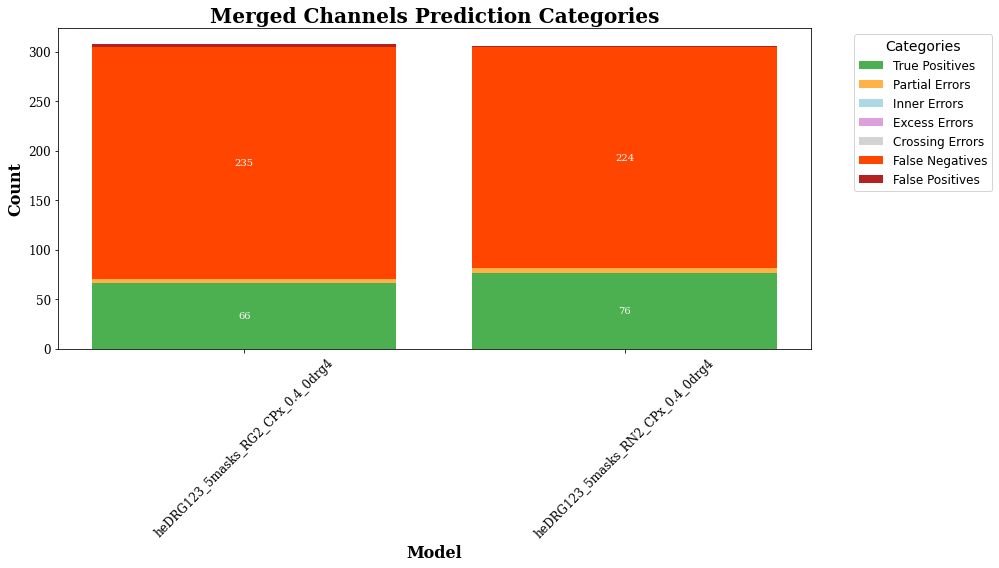

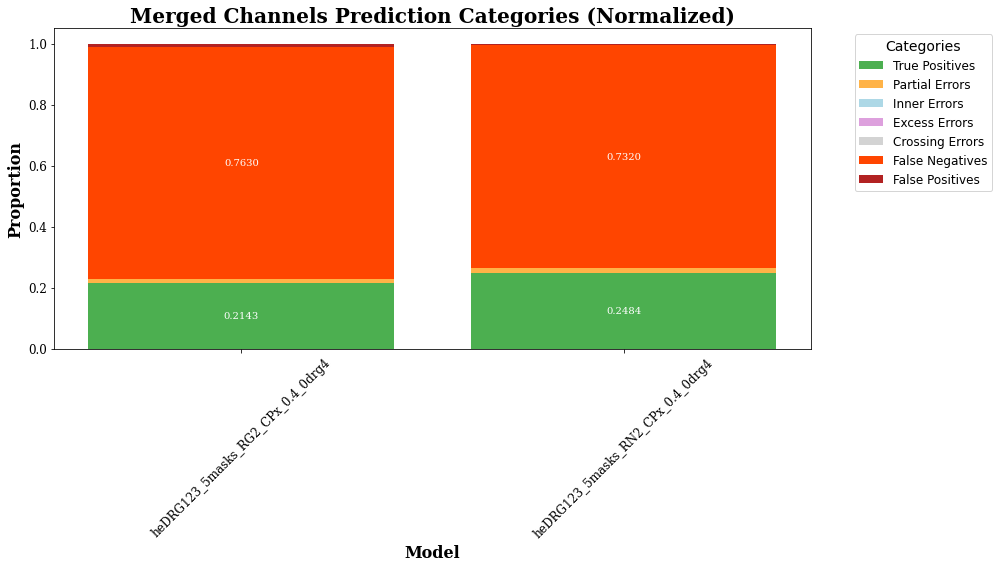

In [3]:
#Inputs: Directory of all metrics csvs, Name of the output svg/title
#Outputs: Bar graph + overall csv of relation categories sorted alphabetically
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import ast
import numpy as np
import numpy as np
import ast
import matplotlib.pyplot as plt
import os

def bar_creation_comparison(folder):
    data = {}
    n = []
    cat = []
    for file in os.listdir(folder):
        if 'csv' in file and 'categories' not in file:
            name = file.replace('.csv', '')
            n.append(name)
            df = pd.read_csv(os.path.join(folder, file))
            l = df['List of Relations'].tolist()[-1]
            cat.append(l)
    data['Name'] = n
    data['Categories'] = cat
    return data

# Define custom colors for categories
colors = {
    'True Positives': '#4CAF50',    # Green for success
    'False Positives': '#B22222',   # Crimson red for false positives
    'False Negatives': '#FF4500',   # Dark orange for false negatives
    'Partial Errors': '#FFB347',    # Light orange for partial errors
    'Inner Errors': '#ADD8E6',      # Light blue for inner errors
    'Excess Errors': '#DDA0DD',     # Light purple for excess errors
    'Crossing Errors': '#D3D3D3'    # Light gray for crossing errors
}

# Explicitly reorder the categories based on increasing alarm
ordered_categories = [
    'True Positives',  
    'Partial Errors', 
    'Inner Errors', 
    'Excess Errors',
    'Crossing Errors',
    'False Negatives', 
    'False Positives',
]

# Helper function to prepare data and generate the stacked bar graph
def plot_stacked_bar_chart(data, categories_dicts, name, comparison_folder, filename_suffix, normalize=False):
    # Extract values for each error type
    values_by_error = {error: [d[error] for d in categories_dicts] for error in ordered_categories}
    
    if normalize:
        # Normalize the values for each bar to sum up to 1
        bar_totals = np.array([sum(d.values()) for d in categories_dicts])  # Sum of each bar's values
        normalized_values_by_error = {}
        for error in ordered_categories:
            normalized_values_by_error[error] = np.array(values_by_error[error]) / bar_totals
        values_by_error = normalized_values_by_error
        ylabel = 'Proportion'
        title = f'{name} Prediction Categories (Normalized)'
        filename = f'{name}CategorizationNormalized.svg'
    else:
        ylabel = 'Count'
        title = f'{name} Prediction Categories'
        filename = f'{name}Categorization.svg'

    # Compute the largest stacked bar height for threshold
    max_total = max(sum(d.values()) for d in categories_dicts)
    threshold = 0.03 * max_total  # Set threshold at 3% of max bar height

    # Set up the stacked bar graph
    x = np.arange(len(data['Name']))  # Positions of the bars
    fig, ax = plt.subplots(figsize=(14, 8))
    cumulative = np.zeros(len(x))

    # Plot each error type as a segment of the stacked bar
    for error in ordered_categories:
        bars = ax.bar(x, values_by_error[error], bottom=cumulative, label=error, color=colors[error])

        # Add text on bars to show numbers
        for bar, value in zip(bars, values_by_error[error]):
            if value > 0.03 and normalize:  # Only display values greater than zero
                ax.text(bar.get_x() + bar.get_width() / 2, 
                        bar.get_y() + bar.get_height() / 2, 
                        f'{value:.4f}',  # Format numbers (e.g., 12.3)
                        ha='center', va='center', fontsize=10, color='white', family='serif')
            elif value > threshold:  # Only display values greater than zero
                ax.text(bar.get_x() + bar.get_width() / 2, 
                        bar.get_y() + bar.get_height() / 2, 
                        f'{int(value)}',  # Format numbers (e.g., 12.3)
                        ha='center', va='center', fontsize=10, color='white', family='serif')

        cumulative += values_by_error[error]  # Update cumulative heights

    # Customize the graph with bold and appealing fonts
    ax.set_xticks(x)
    ax.set_xticklabels(data['Name'], rotation=45, fontsize=12, family='serif')
    plt.yticks(fontsize=12, family='serif')
    ax.set_xlabel('Model', fontsize=16, weight='bold', family='serif')
    ax.set_ylabel(ylabel, fontsize=16, weight='bold', family='serif')
    ax.set_title(title, fontsize=20, weight='bold', family='serif')

    # Customize the legend
    ax.legend(title='Categories', title_fontsize=14, fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig(os.path.join(comparison_folder, filename), format='svg', dpi=300)
    plt.show()

# Read and process data
name = 'Merged Channels'
comparison_folder = '../Channel Comparison/he/drg4'
unordered_data = bar_creation_comparison(comparison_folder)

# Sort data
sorted_indices = sorted(range(len(unordered_data['Name'])), key=lambda i: unordered_data['Name'][i])
data = {key: [values[i] for i in sorted_indices] for key, values in unordered_data.items()}

df = pd.DataFrame(data)
df.to_csv(os.path.join(comparison_folder, 'categories.csv'), index=False)

# Convert 'Categories' to dictionaries
categories_dicts = [ast.literal_eval(cat) for cat in data['Categories']]

# Generate the unnormalized stacked bar chart
plot_stacked_bar_chart(data, categories_dicts, name, comparison_folder, 'Categorization', normalize=False)

# Generate the normalized stacked bar chart
plot_stacked_bar_chart(data, categories_dicts, name, comparison_folder, 'CategorizationNormalized', normalize=True)
